# Signal denoising

**Author: M. Ravasi, KAUST**

Welcome to the third exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to:

- Learn how to use Total Variation regularization with PyProximal;
- Compare the performance of different proximal solvers when applied to the signal denoising for 1D and 2D signals.

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops
import pyproximal

from scipy import misc
from pylops import Identity, FirstDerivative, Gradient
from pylops.utils.metrics import snr

np.random.seed(1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Problem statement

In this exercise, we are concerned with the problem of denoising a piece-wise step function which has been contaminated by noise. The forward model is:

$$
\mathbf{y} = \mathbf{x} + \mathbf{n}
$$

meaning that we have an identity operator ($\mathbf{I}$) and inverting
for $\mathbf{x}$ from $\mathbf{y}$ is impossible without adding
prior information. 

We will enforce blockiness in the solution by adding a regularization term that enforces sparsity in the first derivative of the solution:

$$
argmin_\mathbf{x} \frac{1}{2}  ||\mathbf{y} - \mathbf{I} \mathbf{x}||_2 +
        || \nabla \mathbf{x}||_1
$$

or 

$$
argmin_\mathbf{x} \frac{1}{2}  ||\mathbf{y} - \mathbf{I} \mathbf{x}||_2 +
        || \nabla \mathbf{x}||_{2,1}
$$

Note that since we are dealing with a 1d signal, the isotropic and anisotropic TV are identical.

### 1D signals

Let’s start by creating the input vector $\mathbf{x}$ and add a realization of white gaussian noise $\mathbf{n} \in \mathcal{N}(0,1)$

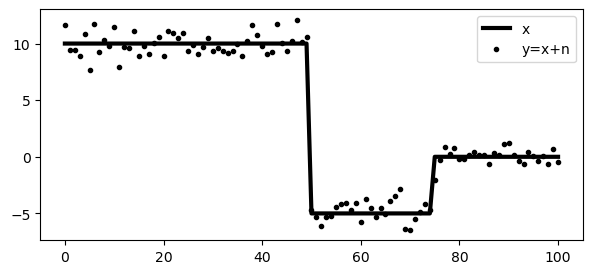

In [3]:
nx = 101
x = np.zeros(nx)
x[: nx // 2] = 10
x[nx // 2 : 3 * nx // 4] = -5

Iop = Identity(nx)
n = np.random.normal(0, 1, nx)
y = Iop * x + n

plt.figure(figsize=(7, 3))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.legend();

We consider now two possible ways to use the ADMM solver

In [4]:
D2op = pylops.FirstDerivative(nx, edge=True, kind='backward')
g = pyproximal.L1(2.)

L = (D2op.H @ D2op).eigs(1)[0].real
tau = 1. / L
mu = tau 
xinv1 = pyproximal.optimization.primal.ADMML2 \
        (g, Iop, y, D2op, np.zeros_like(x),
         tau, niter=500, show=False, iter_lim=100)[0]

In [5]:
D2op = pylops.FirstDerivative(nx, edge=True, kind='backward')
f = pyproximal.L2(Iop, y, niter=20)
g = pyproximal.L1(2.)

L = (D2op.H @ D2op).eigs(1)[0].real
tau = 1.
mu = tau / L
xinv2 = pyproximal.optimization.primal.LinearizedADMM \
        (f, g, D2op, np.zeros_like(x),
         tau, mu, niter=500, show=False)[0]

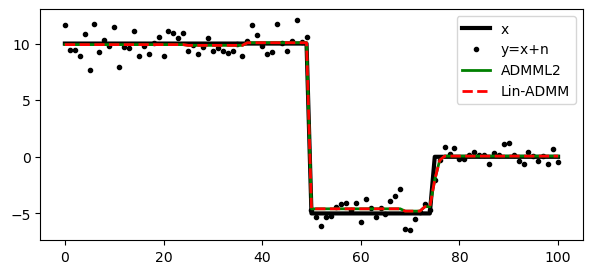

In [6]:
plt.figure(figsize=(7, 3))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.plot(xinv1, "g", lw=2, label="ADMML2")
plt.plot(xinv2, "--r", lw=2, label="Lin-ADMM")
plt.legend();

### 2D signals

We load now a 2D image from scipy and add uniform noise $\mathbf{n} \in \mathcal{U}(-.2,.2)$

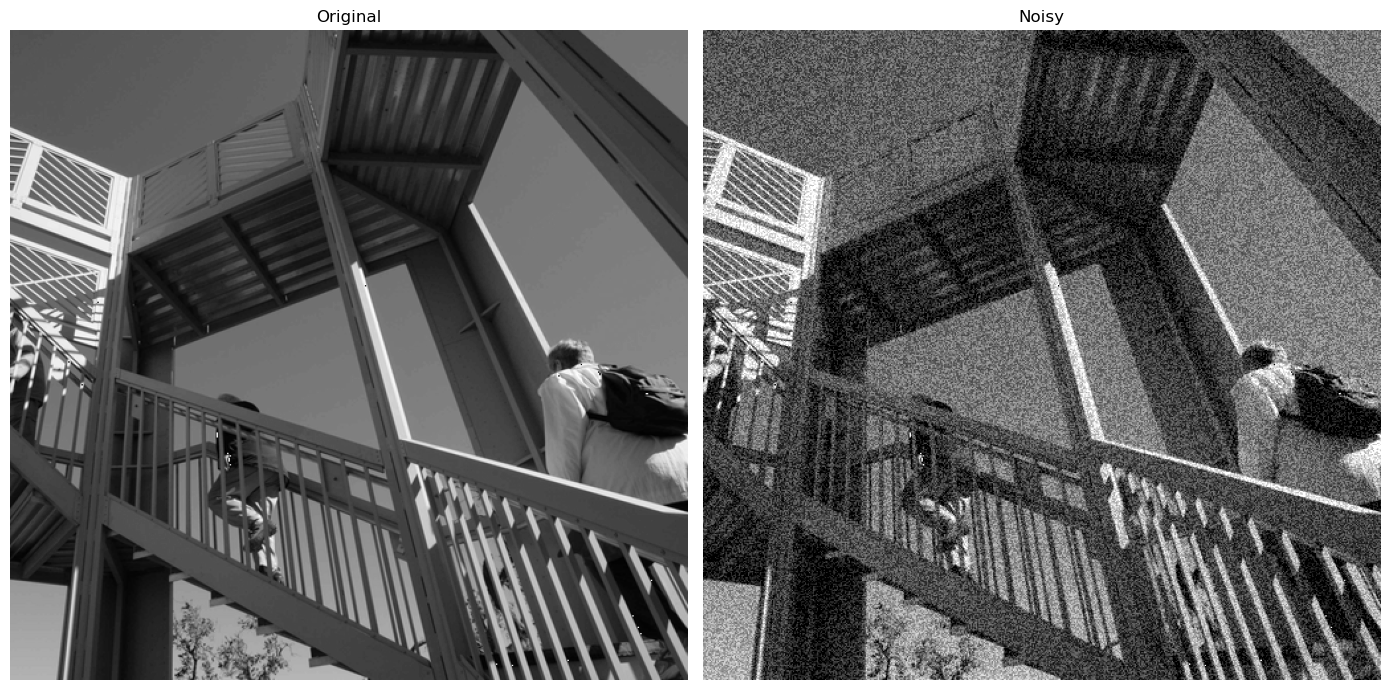

In [7]:
# Load image
img = misc.ascent()
img = img / np.max(img)
ny, nx = img.shape

# Add noise
sigman = .2
n = sigman * np.random.uniform(-1, 1, img.shape)
noise_img = img + n

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(noise_img, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
plt.tight_layout();

At this point we create the gradient operator that will be used in both the anisotropic and isotropic TV regularizations.

In [8]:
# Identity operator
Iop = Identity(ny * nx)

# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False,
               kind='forward', dtype='float64')
L = 8. / sampling ** 2 # maxeig(Gop^H Gop) # Lipschitz constant

In [9]:
# Anisotropic TV with ADMML2
sigma = .1
l1 = pyproximal.L1(sigma=sigma)

# Solve
tau = 1. / L

imaniso = pyproximal.optimization.primal.ADMML2(l1, Iop, noise_img.ravel(), Gop, tau=tau,
                                                x0=np.zeros_like(img.ravel()),
                                                niter=100, show=True)[0]
imaniso = imaniso.reshape(img.shape)
snraniso = snr(img.ravel(), imaniso.ravel())

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 1.250000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   3.26891e-01   2.382e+03   5.261e+02   2.908e+03
     2   3.16230e-01   2.375e+03   4.133e+02   2.789e+03
     3   3.16347e-01   2.187e+03   4.854e+02   2.672e+03
     4   3.17832e-01   2.079e+03   5.383e+02   2.617e+03
     5   3.19213e-01   2.010e+03   5.725e+02   2.583e+03
     6   3.20266e-01   1.963e+03   5.946e+02   2.558e+03
     7   3.21122e-01   1.929e+03   6.095e+02   2.538e+03
     8   3.21763e-01   1.902e+03   6.204e+02   2.523e+03
     9   3.22259e-01   1.881e+03   6.287e+02   2.510e+03
    10   3.22753e-01   1.864e+03   6.355e+02   2.500e+03
    11   3.23447e-01   1.850e+03   6.411e+02   2.491e+03
    21   3.25517e-01   1.780e+03   6.723e+02   2.452e+03
    31   3.25844e-01   1.756e+03   6.854e+02   2.441e+03
    41   3.25754e-01   1.745e+03   6.918e+02   2

In [10]:
# Isotropic TV with ADMML2
sigma = .1
tviso = pyproximal.L21(ndim=2, sigma=sigma)

# Solve
tau = 1. / L

imiso = pyproximal.optimization.primal.ADMML2(tviso, Iop, noise_img.ravel(), Gop, tau=tau,
                                              x0=np.zeros_like(img.ravel()),
                                              niter=100, show=True)[0]
imiso = imiso.reshape(img.shape)
snriso = snr(img.ravel(), imiso.ravel())

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
tau = 1.250000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   3.26891e-01   2.382e+03   4.173e+02   2.799e+03
     2   3.17965e-01   2.318e+03   3.575e+02   2.676e+03
     3   3.20549e-01   2.123e+03   4.342e+02   2.557e+03
     4   3.22886e-01   2.011e+03   4.870e+02   2.498e+03
     5   3.24336e-01   1.938e+03   5.234e+02   2.461e+03
     6   3.25381e-01   1.885e+03   5.504e+02   2.435e+03
     7   3.26274e-01   1.845e+03   5.712e+02   2.416e+03
     8   3.27109e-01   1.814e+03   5.878e+02   2.402e+03
     9   3.27895e-01   1.789e+03   6.015e+02   2.390e+03
    10   3.28626e-01   1.768e+03   6.130e+02   2.381e+03
    11   3.29304e-01   1.751e+03   6.227e+02   2.374e+03
    21   3.33706e-01   1.665e+03   6.761e+02   2.342e+03
    31   3.35375e-01   1.636e+03   6.973e+02   2.334e+03
    41   3.36134e-01   1.623e+03   7.076e+02  

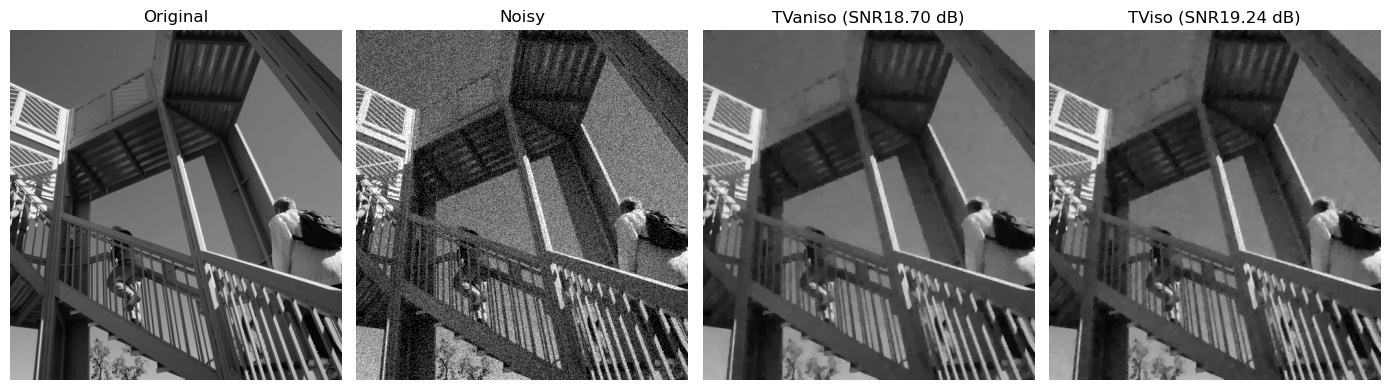

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(noise_img, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imaniso, cmap='gray', vmin=0, vmax=1)
axs[2].set_title(f'TVaniso (SNR{snraniso:.2f} dB)')
axs[2].axis('off')
axs[2].axis('tight')
axs[3].imshow(imiso, cmap='gray', vmin=0, vmax=1)
axs[3].set_title(f'TViso (SNR{snriso:.2f} dB)')
axs[3].axis('off')
axs[3].axis('tight')
plt.tight_layout();

## Recap

In this tutorial we have learned to:

- How to set up anisotropic and Isotropic Total Variation in PyProximal;
- How to solve 1D and 2D denoising problems.